## Quick draft for the road stations. Copying and pasting here the Quarto notebook contents


In [4]:
import warnings
warnings.filterwarnings('ignore')
import os

import geopandas as gpd
import folium as fl
# danish data: https://github.com/ok-dk/dagi
import pandas as pd

stations_vv = gpd.read_file("data/vejvejr_stations_ll.shp")
stations_vv.head(10)
m = fl.Map(zoom_start=100, layers_control=True, tiles="OpenStreetMap")
for _, r in stations_vv.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = fl.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    geo_j.add_to(m)
m    





### load domain that includes north jutland's tip, which I selected using leafmap before


In [8]:
df_njl = gpd.read_file("data/DK/nordjylland.shp") # this one is the whole thing
df_njl = gpd.read_file("nordjylland.geojson")
stations_vv.crs = {'init': 'EPSG:4326'}
points_njl = gpd.sjoin(stations_vv, df_njl, op = 'within')
points_njl

,geometry,index_right
804,POINT (9.98219 57.58002),0
805,POINT (10.03619 57.48264),0
806,POINT (10.03619 57.48264),0
807,POINT (10.53284 57.45390),0
808,POINT (10.41964 57.44886),0
...,...,...
1018,POINT (9.87193 57.09639),0
1019,POINT (9.87198 57.09615),0
1020,POINT (9.83833 57.09410),0
1021,POINT (9.83842 57.09407),0


### Now checking the whole data set. Reading the stations database, observational data  and forecast data.


In [7]:
import sqlite3
import pandas as pd
dbase="data/stations_coords_height.db"
con=sqlite3.connect(dbase)
com="SELECT * FROM roadstations"
df_stations = pd.read_sql(com,con)
con.close()

# read the observational data
OBS="/home/cap/Downloads/OBSTABLE_TROAD_2023.sqlite"

com="SELECT * FROM SYNOP"
con=sqlite3.connect(OBS)
df_obs = pd.read_sql(com,con)
con.close()

# read the forecast data from hour 00 or 12
FCST="/home/cap/Downloads/FCTABLE_TROAD_202301_00.sqlite"
FCST="/home/cap/Downloads/FCTABLE_TROAD_202301_12.sqlite"

com="SELECT * FROM FC"
con=sqlite3.connect(FCST)
df_fcst = pd.read_sql(com,con)
con.close()


Now for convenience we add some extra geo data to the observational data set, making it
geopandas dataframe. This way we can select data over a specific domain.


In [9]:
gdf_obs = gpd.GeoDataFrame(
    df_obs, geometry=gpd.points_from_xy(df_obs.lon, df_obs.lat), crs="EPSG:4326"
)

selected_obs = gpd.sjoin(gdf_obs, df_njl, op = 'within')
unique_ID=selected_obs['SID'].unique()


Now we can do the same for the forecast data, but just using the list of stations from the previous step.


In [10]:
selected_fcst =df_fcst[df_fcst["SID"].isin(unique_ID)]


Some datetime tasks below, to select specific periods. The index list will allow me to select specific hours.


In [11]:
MONTH=1
LAST=31
YEAR=2023
from datetime import datetime
beg_month = datetime(YEAR,MONTH,1)
end_month = datetime(YEAR,MONTH,LAST)

selected_obs["datetime"]=pd.to_datetime(selected_obs["validdate"],unit="s")
selected_fcst["datetime"] = pd.to_datetime(df_fcst["validdate"],unit="s")


In [60]:
# january obs, jan forecast

jan_obs = selected_obs[(selected_obs["datetime"] >= beg_month) & (selected_obs["datetime"] <= end_month)]
index = pd.DatetimeIndex(jan_obs['datetime'])

noon_obs=jan_obs.iloc[index.indexer_between_time('10:00','14:00')]
#noon_obs["TROAD"].plot.hist()
noon_obs[["SID","datetime"]].head(20)

jan_fcst = selected_fcst[(selected_fcst["datetime"] >= beg_month) & (selected_fcst["datetime"] <= end_month)]
index = pd.DatetimeIndex(jan_fcst['datetime'])

noon_fcst=jan_fcst.iloc[index.indexer_between_time('10:00','14:00')]



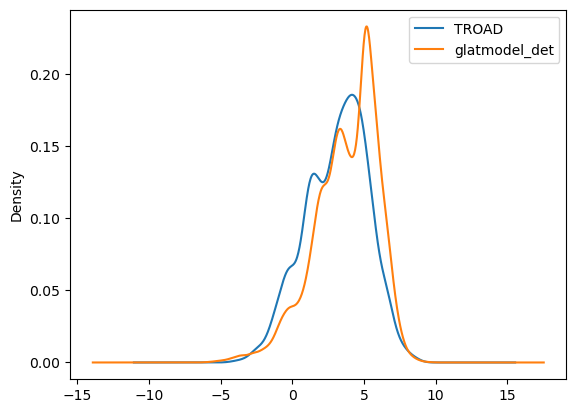

In [14]:
from matplotlib import pyplot as plt
noon_obs["TROAD"].plot.density(legend="obs")#hist(alpha=0.5)
noon_fcst["glatmodel_det"].plot.density(legend="fcst")#.hist()

plt.show()

# Extra: select only days devoided of clouds using the clouds database

In [63]:
CLOUDS="/home/cap/Downloads/clouds_vejvejr_2023.db"

com="SELECT * FROM clouds"
con=sqlite3.connect(CLOUDS)
df_clouds = pd.read_sql(com,con)
con.close()
df_clouds.head()


,stationID,stationName,date,lat,lon,cloud
0,100000,Noname,20230101000000,55.995622,12.486437,17
1,100000,Noname,20230101110000,55.995622,12.486437,8
2,100000,Noname,20230101130000,55.995622,12.486437,8
3,100000,Noname,20230101090000,55.995622,12.486437,10
4,100000,Noname,20230101190000,55.995622,12.486437,16


In [64]:
df_obs.head()

,validdate,SID,lat,lon,elev,TROAD,geometry
0,1673402400,100001,55.995688,12.48658,58.560295,3.8,POINT (12.48658 55.99569)
1,1673406000,100001,55.995688,12.48658,58.560295,3.9,POINT (12.48658 55.99569)
2,1673409600,100001,55.995688,12.48658,58.560295,4.0,POINT (12.48658 55.99569)
3,1673413200,100001,55.995688,12.48658,58.560295,4.2,POINT (12.48658 55.99569)
4,1673416800,100001,55.995688,12.48658,58.560295,4.8,POINT (12.48658 55.99569)


In [65]:
# some datetime converstions
import datetime as dt
from datetime import timezone
def ts2date(ts):
    return dt.datetime.utcfromtimestamp(ts)
def date2ts(date,dformat="%Y%m%d%H%M%S"):
    dtime = dt.datetime.strptime(date,dformat)
    return dtime.replace(tzinfo=timezone.utc).timestamp()
    


In [66]:
df_clouds["validdate"] = [int(date2ts(d)) for d in df_clouds["date"]]

In [67]:
df_clouds.head()

,stationID,stationName,date,lat,lon,cloud,validdate
0,100000,Noname,20230101000000,55.995622,12.486437,17,1672531200
1,100000,Noname,20230101110000,55.995622,12.486437,8,1672570800
2,100000,Noname,20230101130000,55.995622,12.486437,8,1672578000
3,100000,Noname,20230101090000,55.995622,12.486437,10,1672563600
4,100000,Noname,20230101190000,55.995622,12.486437,16,1672599600


In [68]:
df_clouds.tail()

,stationID,stationName,date,lat,lon,cloud,validdate
302893,136000,Noname,20230113100000,55.72175,12.385686,10,1673604000
302894,136000,Noname,20230113150000,55.72175,12.385686,16,1673622000
302895,136000,Noname,20230113220000,55.72175,12.385686,8,1673647200
302896,136000,Noname,20230113080000,55.72175,12.385686,19,1673596800
302897,136000,Noname,20230113010000,55.72175,12.385686,1,1673571600


In [97]:
def cloudiness(ts,SID,df_clouds):
    sel_clouds = df_clouds[(df_clouds["stationID"] == SID) & (df_clouds["validdate"] == ts)]
    if sel_clouds.empty:
        #print(f"error on {ts} {SID}")
        return 999
    else:
        return sel_clouds["cloud"].values[0]


In [89]:
cloudiness(1673431200,600101,df_clouds)
#df_clouds[(df_clouds["validdate"] == 1673604000)&(df_clouds["stationID"] == 600101)]

#df_clouds[(df_clouds["stationID"] == 600101)]
noon_obs[(noon_obs["SID"] == 600101)&(noon_obs["validdate"] == 1673431200)]

,validdate,SID,lat,lon,elev,TROAD,geometry,index_right,datetime
259250,1673431200,600101,57.482639,10.036187,29.049749,6.4,POINT (10.03619 57.48264),0,2023-01-11 10:00:00


In [103]:
# select validdate where clouds equal 1 or 2 (none or little clouds)

clouds_sel=[]
for k,ts in enumerate(noon_obs["validdate"]):
    clouds_sel.append(cloudiness(ts,noon_obs["SID"].values[k],df_clouds))
    #if (ts == 1673431200) & (noon_obs["SID"].values[k] == 600101):
    #    print(k)
    #    clouds_sel.append(cloudiness(ts,noon_obs["SID"].values[k],df_clouds))
#noon_obs["clouds"]=[cloudiness(ts,noon_obs["SID"].values[k],df_clouds) for k,ts in enumerate(noon_obs["validdate"])]
#clouds_sel

In [104]:
noon_obs.head()

,validdate,SID,lat,lon,elev,TROAD,geometry,index_right,datetime,cloud
259250,1673431200,600101,57.482639,10.036187,29.049749,6.4,POINT (10.03619 57.48264),0,2023-01-11 10:00:00,6
259251,1673434800,600101,57.482639,10.036187,29.049749,6.5,POINT (10.03619 57.48264),0,2023-01-11 11:00:00,1
259252,1673438400,600101,57.482639,10.036187,29.049749,6.6,POINT (10.03619 57.48264),0,2023-01-11 12:00:00,8
259253,1673442000,600101,57.482639,10.036187,29.049749,6.4,POINT (10.03619 57.48264),0,2023-01-11 13:00:00,10
259254,1673445600,600101,57.482639,10.036187,29.049749,6.0,POINT (10.03619 57.48264),0,2023-01-11 14:00:00,1


In [100]:
noon_obs["cloud"] = clouds_sel

In [105]:
clear_sky_noon = noon_obs[noon_obs["cloud"]  == 1 ]

In [106]:
#noon_obs[~noon_obs.clouds.isin([1,2])]

In [107]:
#df_clouds[df_clouds["validdate"] == 1673431200]

In [108]:
#df_clouds[df_clouds["date"] == "20230111100000"].validdate.values[0]

In [109]:
#df_clouds[df_clouds["date"] == "20230111100000"].stationID.values[0]

In [110]:
#noon_obs[noon_obs["validdate"] == 1673431200 ]

In [111]:
#df_clouds[(df_clouds["validdate"] == 1673431200)&(df_clouds["stationID"] == 600101)]

In [112]:
#noon_obs[(noon_obs["validdate"] == 1673431200)&(noon_obs["SID"] == 600101)]

<AxesSubplot:ylabel='Density'>

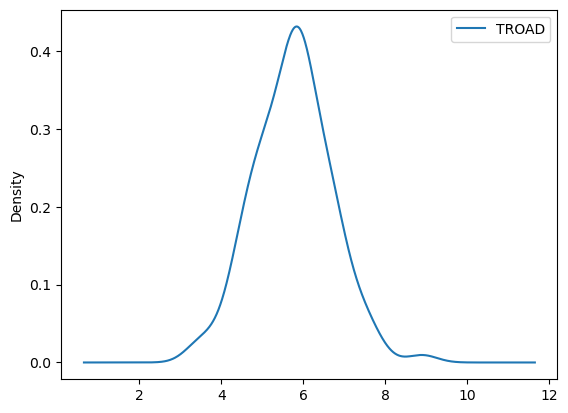

In [113]:
clear_sky_noon["TROAD"].plot.density(legend="obs")#.hist()


In [116]:
# select all in the first 6 hours
index = pd.DatetimeIndex(jan_obs['datetime'])

obs_12_18=jan_obs.iloc[index.indexer_between_time('12:00','18:00')]

clouds_sel=[]
for k,ts in enumerate(df_obs["validdate"]):
    clouds_sel.append(cloudiness(ts,df_obs["SID"].values[k],df_clouds))
obs_12_18["cloud"] = clouds_sel

KeyboardInterrupt: 